# TSA Passenger Screening Algorithm Challenge
## Final Project Report
### CSE627 | Fall 2017 | Dr. Femiani

- Matt DePero
- Harrison Roth
- Cole Hoffbauer

In [ ]:
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import os

%pylab inline

# Project Description
While long lines and frantically shuffling luggage into plastic bins isn’t a fun experience, airport security is a critical and necessary requirement for safe travel.

No one understands the need for both thorough security screenings and short wait times more than U.S. Transportation Security Administration (TSA). They’re responsible for all U.S. airport security, screening more than two million passengers daily.

As part of their Apex Screening at Speed Program, DHS has identified high false alarm rates as creating significant bottlenecks at the airport checkpoints. Whenever TSA’s sensors and algorithms predict a potential threat, TSA staff needs to engage in a secondary, manual screening process that slows everything down. And as the number of travelers increase every year and new threats develop, their prediction algorithms need to continually improve to meet the increased demand.

Currently, TSA purchases updated algorithms exclusively from the manufacturers of the scanning equipment used. These algorithms are proprietary, expensive, and often released in long cycles. In this competition, TSA is stepping outside their established procurement process and is challenging the broader data science community to help improve the accuracy of their threat prediction algorithms. Using a dataset of images collected on the latest generation of scanners, participants are challenged to identify the presence of simulated threats under a variety of object types, clothing types, and body types. Even a modest decrease in false alarms will help TSA significantly improve the passenger experience while maintaining high levels of security.

This is a two-stage competition. Please read our two-stage FAQs to understand more about what this means.

All persons contained in the dataset are volunteers who have agreed to have their images used for this competition. The images may contain sensitive content. We kindly request that you conduct yourself with professionalism, respect, and maturity when working with this data.

# Initial Data Analysis
We began our project with the data you provided based on the formatting done by Johnny. This was a good starting point because it made the data a lot smaller and easier to work with on our computers. From there, we combined all of the perspectives for each person into one long image. We figured this would allow the neural net to learn more accurately as it could see the entire 360 degree rotation of a person instead of looking at each pose separately. 

We considered doing many other things before we finally settled on this format. We considered chopping off the empty space from the tops and bottoms of the images and resizing them to be the same original size in order to eliminate any variance from height and width of the people. This variance would affect where the zones lie in the image itself which we thought may in turn affect how the weights were calculated in the net. We ended up not doing this and saved it for a possible improvement later on if we had extra time because it was more important to get a neural net up and running and get a kaggle submission in. We also considered not combining all of the perspectives into one image and creating different nets for each perspective image so that we would have a net for each perspective that would work with all of the other nets to be a sort of ensemble of nets. The combined predictions would give us an average that might have been more accurate than a general net. We ended up not going this direction because we thought it would be more complicated than making a general net. 


In [43]:
# === READ META DATA FROM CSV FILE ===

ps = 4   # num of perspectives after processing
psa = 16 # number of original perspectives
zs = 17  # num of outputs zones

ids = []
targets = OrderedDict()
with open('labels.csv') as f:
    header = f.readline()
    for line in f:
        idzone, label = line.split(',')
        sampleid, zone = idzone.split('_')
        zone_number = int(zone[len('Zone'):]) # string looks like "Zone8" so this chops off "Zone"
        zone_number -= 1
        
        if sampleid not in targets:
            ids.append(sampleid)
            targets[sampleid] = np.zeros(zs)
        targets[sampleid][zone_number] = float(label)

random.shuffle(ids) # add randomness to list by modifying meta data

In [44]:
# === GET LABEL COUNTS ===
counts = zeros(len(targets[ids[0]]))
blanks = 0
for sid in ids:
    empty = True
    for i in range(len(targets[sid])):
        if targets[sid][i] == 1:
            empty = False
            counts[i] += 1
    if empty:
        blanks += 1

### Label Distributions
The first analysis we do is on the labels provided to use for our data. 

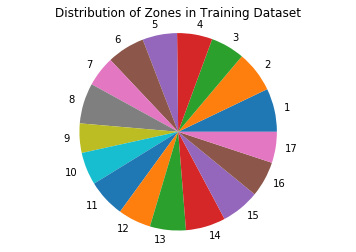

In [45]:
labels = [x+1 for x in range(zs)]

fig1, ax1 = plt.subplots()
plt.title("Distribution of Zones in Training Dataset")
ax1.pie(counts, labels=labels)
ax1.axis('equal')

plt.show()

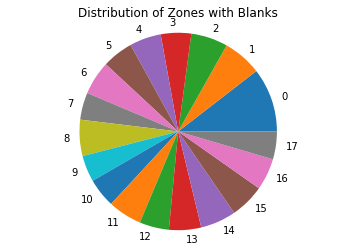

In [46]:
labels = range(zs+1)
with_blank = np.insert(counts, 0, blanks)

fig1, ax1 = plt.subplots()
plt.title("Distribution of Zones with Blanks")
ax1.pie(with_blank, labels=labels)
ax1.axis('equal')

plt.show()

In [57]:
# === LOAD AN IMAGE ===
w =  512 * ps
w2 = 512 * psa
h =  660
ath = 'data/{}.aps.npz'.format(sid)

npzfile = np.load(path)
data_all = npzfile['arr_0']
data_all = np.moveaxis(data_all, 2, 0)
data = np.zeros((ps, int(w/ps), h))
data[0] = data_all[4]
data[1] = data_all[8]
data[2] = data_all[12]
data[3] = data_all[0]

data_all = np.reshape(data_all, [w2,h])
data = np.reshape(data, [w,h])

# Implementation

## Design Goals

Build a Convolutional Neural Net that will effectively predict the probability that something dangerous exists in any zone 1-17 from the set of data given by the Kaggle competition - Passenger Screening Algorithm Challenge. We wanted to design a net that could run on an Nvidia GTX 1080 using tensorflow. 

## Initial Iteration

The first iteration of our neural net was based on the convolutional neural network tutorial on the within the tensorflow docs. The tutorial was for the MNIST dataset, so we modified it for the TSA problem. The tutorial net was fairly simple with only two convolutional layers, two pooling layers, and two fully connected layers. The tutorial didn't abstract away as much as many other convolutional neural net tutorials. It allowed us to make modifications at a lower level due to the specific tensorflow functions that were used. 
### [Link to code](https://github.com/mdepero/tsa/blob/master/Naive%20Simple%20CNN%20-%20Matt.ipynb) 
We trained this net for a few days, but at the end didn't see much improvement in its predictions. With the way we were evaluating, comparing it's guesses to the actual values, it was only 8% accurate after a few days of training. After discussing why this was the case with Dr. Femiani, he gave us the advice that we should try and use an existing well known CNN design and adapt it to our problem. We decided to scrap this net and go with VGG for the second iteration. 

## Second Iteration
After deciding that our neural net design might be one of the problems, we looked at VGG and GoogleNet. We decided that VGG would be the better decision due to its simplicity. We figured that we would be more likely to understand VGG and be able to implement it effectively than we would have with GoogleNet. It also seemed like we would have more control over the VGG implementation and could adjust it more than GoogleNet. 

We started by directly taking the number of  layers and order of layer types from an implementation of VGG that worked on the MNIST data set and fitting our data into the first layer. We initially used a similar number of layers but it was too big fit on our GPU, so we were forced to scale down the size significantly in order to have a decent batch size.  
### [Link to code](https://github.com/mdepero/tsa/blob/master/VGG%20Iteration%201.ipynb)
The accuracy of the model was very bad, it was only slightly better than random guessing based on the way we were gauging the accuracy of our model. 

The model didn’t run very efficiently on the GPU, there was significant amount of idling between batches when the data was being copied on and off of the GPU. This was due to how much we reduced the size of the net. The net was so small that the bottleneck became loading images instead of the computation of the net.

## Final Design
After the issues with our initial VGG net, we increased the depth of the net to fix the idling problem. After editing the net, we essentially had no idling on the GPU, which meant we were being as efficient as we are likely to get.
### [Link to code](https://github.com/mdepero/tsa/blob/master/VGG%20Final%20Iteration.ipynb)  
We ran the model for a few days and were unable to get past 40% accuracy, according to our test. So we played with some of the details of the model and were unable to get much of a difference. So we decided to print out the values for each prediction to assess what was going wrong. We found out that our model was outputting the same values (.05555556%) for each zone for each prediction. This realization caused some significant issues, we were not aware before this how wrong our predictions were. 

So we decided that one problem might be based upon the weights that were being assigned to incorrect values. To remedy this potential problem, we took the cost of each predictiction, let it be x, and applied this formula e1/(1-x). This unfortunately didn’t cause any change in our predictions.

Next we decided to remove all empty training data, those being any images which had no items in any zones. This also didn’t have any impact on our predictions. At this point, we were very frustrated that none of these changes made any difference in our model. 

The last change we decided to try was to simplify the image to only the front, back, and side perspectives as well as deepen the net. This also didn’t help the predictions, but unfortunately we didn’t have time to make any other modifications to improve the model. Because of this, we never submitted to the actual Kaggle competition. None of our nets were successful and they all guessed the same percentage for each zone for each person. We aren't sure why our net turned out this way, every indication we had for the source of the problem was turned into a potential solution. But none of those potential solutions ended up being true solutions to our problems.


### Before
Our original processed image

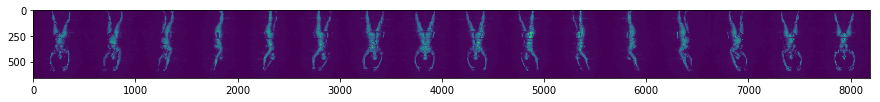

In [55]:
from matplotlib.pyplot import imshow 
figsize(15,4)
im = imshow(np.flipud(data_all).T, cmap = 'viridis')

### After
Reducing our image into only the most important perspectives

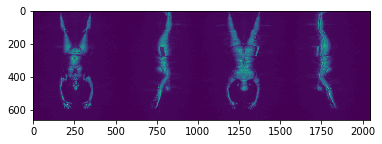

In [59]:
from matplotlib.pyplot import imshow 
figsize(15,2)
im = imshow(np.flipud(data).T, cmap = 'viridis')

# Conclusions / Lessons Learned

Throughout this process we tried a bunch of different methods to try and fix our various iterations, but none of them ended up working. We are still fairly proud of our problem solving process and feel like we learned a lot about the actual structure of convolutional neural nets, implementing them with tensorflow, and running them on a GPU. The root of our problems was the method in which we evaluated how our nets were doing. It abstracted the predictions into simple 1 or 0 guesses instead of looking at the actual predictions. Because of this we didn't realize how many problems we were actually having with our nets until our final iteration. We tried everything we could, but couldn't get a net to learn intelligently. Maybe we needed more time for training, maybe our cost function was inherently wrong, maybe we overestimated what a net could actually do with the images we gave it. We aren't sure what the root of the problem was, but we did gain valuable insights into working through a difficult problem where the only solutions we could find were our own because there was no prior "correct" answer.

## References
- http://www.cs.toronto.edu/~frossard/post/vgg16/
- https://www.kaggle.com/c/passenger-screening-algorithm-challenge
- https://www.tensorflow.org/tutorials/layers